<a href="https://colab.research.google.com/github/ACSE-mct22/acse_presessional/blob/main/Server.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycm livelossplot
%pylab inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 232 kB/s 
     |████████████████████████████████| 595 kB 12.6 MB/s 
Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, ToPILImage, RandomRotation, RandomHorizontalFlip
import torch.nn as nn
import numpy as np
from livelossplot import PlotLosses
import random
import torch.nn.functional as F
from torchsummary import summary

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

set_seed(0)
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [5]:
class FashionDataset(Dataset):
    def __init__(self, data, targets, transform=Compose([ToTensor()])):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, target = self.data[idx], self.targets[idx]
        image = image/255 # reduce to values between 0 and 1
        if self.transform:
            image = self.transform(image)

        return image, target

In [6]:
def import_images(transform=None, batch_size=128):
  """Imports the images, makes a FashionDataset out of them and applies the transformations"""

  ds_train = FashionMNIST('./', download=True, train=True)
  ds_test = FashionMNIST('./', download=True, train=False)

  # concatenate
  data = torch.cat((ds_train.data, ds_test.data), dim=0)
  data = data.view(-1, 1, 28, 28)
  targets = torch.cat((ds_train.targets, ds_test.targets), dim=0)

  ds = FashionDataset(data, targets, transform=transform)
  print("Length of final dataset:", len(ds))

  dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

  return ds, dataloader

dataset, data = import_images()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

Length of final dataset: 70000


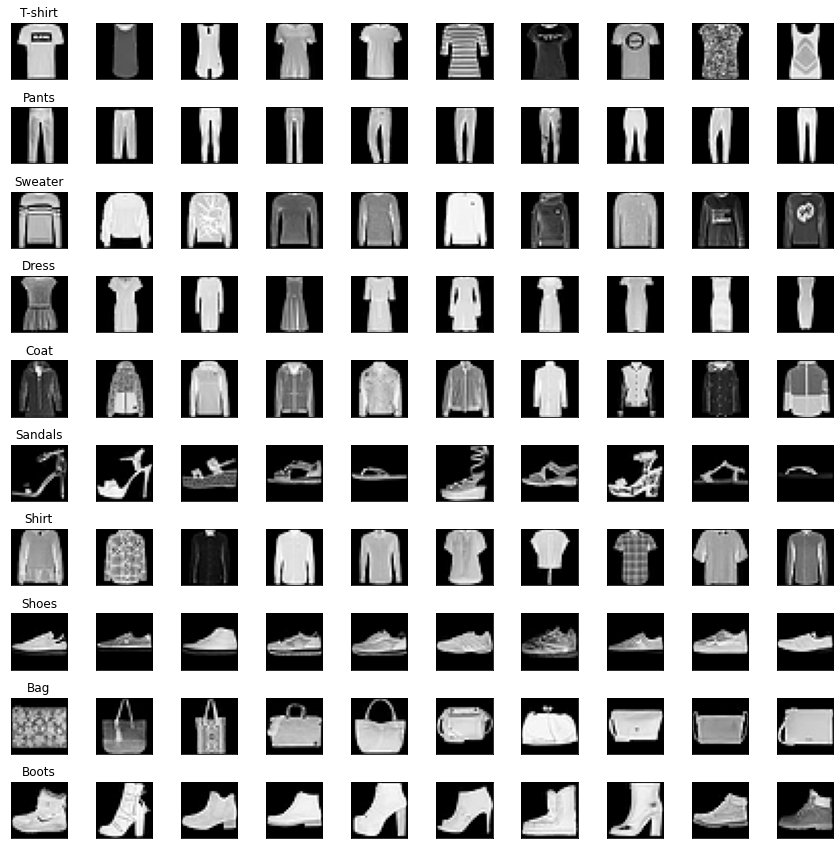

In [7]:
def plot_images(axs, name, data):
  """Plot 10 images of a specific garment"""
  for ax, image in zip(axs, data):
    ax.imshow(image[0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
  axs[0].title.set_text(name)

# Associate each label to the garment name
garments = {0: 'T-shirt',
            1: 'Pants',
            2: 'Sweater',
            3: 'Dress',
            4: 'Coat',
            5: 'Sandals',
            6: 'Shirt',
            7: 'Shoes',
            8: 'Bag',
            9: 'Boots'}

fig, axs = plt.subplots(10, 10, figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
for num, name in garments.items():
  idx = torch.where(dataset.targets == num)[0][:10]
  plot_images(axs[num], name, dataset.data[idx])

In [8]:
def encode_labels(idx, length):
  """Encodes list of labels as a matrix of one-hot-encoded labels"""
  return F.one_hot(idx.to(torch.int64), num_classes=length)

# GAN

In [9]:
# label length
lle = 10

# Hyperparameters
criterion = nn.BCELoss() 
z_dim = 100
lr = 0.0001

# Augmented dataset
transformation = Compose([ToPILImage(), RandomHorizontalFlip(p=0.5), RandomRotation(5), ToTensor()])
dataset_gan, data_gan = import_images()

Length of final dataset: 70000


In [14]:
class Generator(nn.Module):
    def __init__(self, g_input_dim=z_dim, g_output_dim=28*28, g_label_dim=10):
        # we initialise with an input layer that can include the encoded label
        super().__init__()
        self.lle = g_label_dim     
        self.fc1 = nn.Linear(g_input_dim+g_label_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, 784)

    def input_encoder(self, z, labels):
        """Takes a list of labels, one-hot-encodes them and adds them to the images"""
        labels = encode_labels(labels, self.lle).to(device)
        z = torch.cat((z, labels), dim=1)
        return z

    def forward(self, x, labels): 
        x = self.input_encoder(x, labels) # feed labels to generator
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.relu(self.fc3(x)) # change
        x = torch.tanh(self.fc4(x))

        return x.view(-1, 28*28)
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim=28*28, d_label_dim=10):
        super().__init__()
        self.lle = d_label_dim

        # Added convolution layers
        self.conv1 = nn.Conv2d(1, 2, kernel_size=(3,3))
        self.conv2 = nn.Conv2d(2, 4, kernel_size=(3,3))
        self.conv3 = nn.Conv2d(4, 8, kernel_size=(3,3))

        # batch normalisation after each convolutional layer
        self.bn1 = nn.BatchNorm2d(2)
        self.bn2 = nn.BatchNorm2d(4)
        self.bn3 = nn.BatchNorm2d(8)

        self.fc1 = nn.Linear(3872+d_label_dim, 1024) # new input size
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    def input_encoder(self, x, labels):
        """Takes a list of labels, one-hot-encodes them and adds them to the images"""
        labels = encode_labels(labels, self.lle).to(device)
        x = torch.cat((x, labels), dim=1) 
        return x
    
    def forward(self, x, labels=torch.Tensor([1])):
        x = x.view(-1, 1, 28, 28)
        x = self.bn1(self.conv1(x))
        x = self.bn2(self.conv2(x))
        x = self.bn3(self.conv3(x))
        #print(x.size())

        x = x.view(-1, 3872) #change 968 - 3872
        x = self.input_encoder(x, labels.to(device)) # feed labels to discriminator
        x = F.leaky_relu(self.fc1(x), 0.02)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.02)
        x = F.dropout(x, 0.3)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))
    
# build models and their optimizers
G = Generator().to(device)
D = Discriminator().to(device)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)

In [11]:
def D_train(x, labels):
    """Discrimator which trains on real and fake data and outputs its loss"""

    D.train()
    D_optimizer.zero_grad()

    # Real data
    x_real, y_real = x.view(-1, 28*28), torch.ones(x.size(0), 1)
    x_real, y_real, labels = x_real.to(device), y_real.to(device), labels.to(device)

    D_output = D(x_real, labels)
    D_real_loss = criterion(D_output, y_real)

    # Fake data
    z = torch.randn(x.size(0), z_dim).to(device) # random latent vector selection
    labels = torch.randint(0, 10, (x.size(0),)).to(device) # random labels
    x_fake, y_fake = G(z, labels).to(device), torch.zeros(x.size(0), 1).to(device)

    D_output = D(x_fake, labels)
    D_fake_loss = criterion(D_output, y_fake)

    # Total loss
    D_loss = D_real_loss + D_fake_loss

    # Model parameters update
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [12]:
def G_train(labels):
    """Generator which produces new images from latent space selection and encoded labels"""
    G.train()
    G_optimizer.zero_grad()

    # Sample latent space
    z = torch.randn(len(labels), z_dim).to(device)
    G_output = G(z, labels).to(device)
    labels = labels.to(device)

    # obtain scores from D for the generated data
    D_output = D(G_output, labels)

    # train generator to "fool" discriminator
    y = torch.ones(len(labels), 1).to(device)
    G_loss = criterion(D_output, y)

    # model update 
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

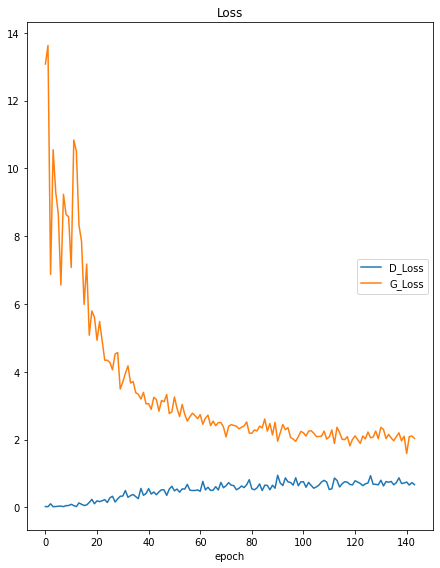

Loss
	D_Loss           	 (min:    0.018, max:    0.947, cur:    0.671)
	G_Loss           	 (min:    1.589, max:   13.630, cur:    2.033)


KeyboardInterrupt: ignored

In [15]:
def train_gan(data, model_name, epochs=200):
  groups = {'Loss': ['D_Loss', 'G_Loss']}
  liveloss = PlotLosses(groups=groups)

  for epoch in range(1, epochs+1):  
    D_losses, G_losses = [], []
    logs = {}
    for batch, labels in data:
      logs['D_Loss'] = D_train(batch, labels)
      idx = torch.randperm(len(labels)) # shuffle since generator labels can be random in train mode
      logs['G_Loss'] = G_train(labels[idx])
    liveloss.update(logs)
    liveloss.draw()

    # save
    if(np.mod(epoch, 20) == 0):
      torch.save(G.state_dict(), "./gdrive/MyDrive/models/Generator_{}_{:03d}.pth".format(model_name, epoch))
      torch.save(D.state_dict(), "./gdrive/MyDrive/models/Discriminator_{}_{:03d}.pth".format(model_name, epoch))

train_gan(data_gan, "Conditional_Generator_Conv_Relu_", epochs=200)

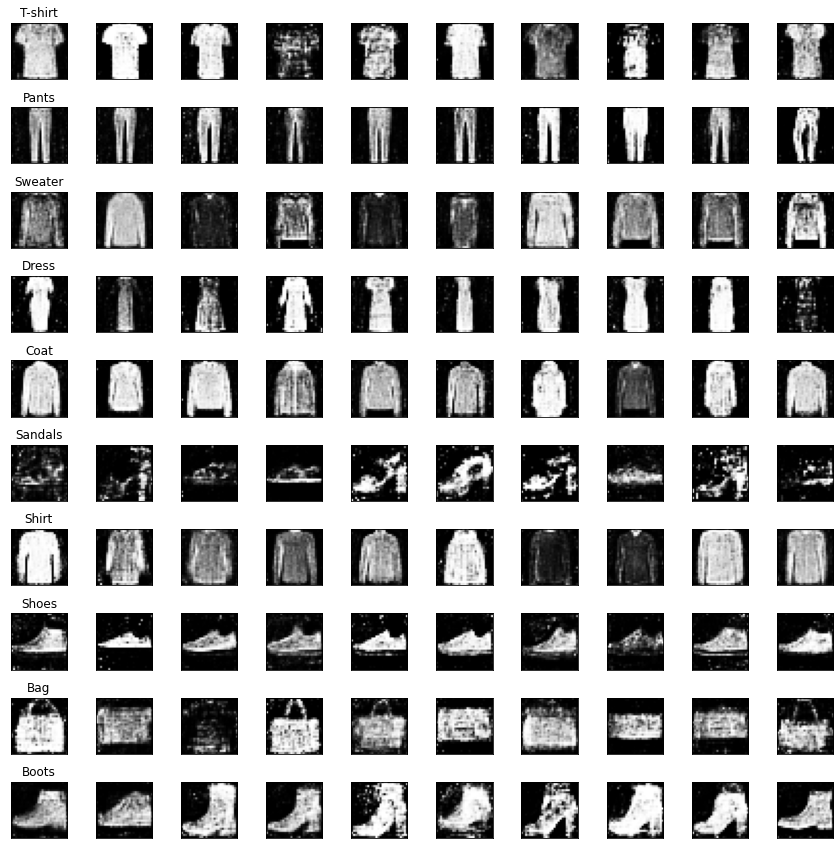

In [16]:
epoch = 80
#G.load_state_dict(torch.load("./gdrive/MyDrive/models/Generator_Conditional_Conv_Relu_Augmented_{:03d}.pth".format(epoch)))

def generate_images_gan(model, num, count=10):
  with torch.no_grad():
    test_z = torch.randn(count, z_dim).to(device)
    labels = torch.full((count,), num).to(device)
    return model(test_z, labels).view(-1, 1, 28, 28)

fig, axs = plt.subplots(10, 10, figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
for num, name in garments.items():
  new_images = generate_images_gan(G, num)
  plot_images(axs[num], name, new_images.cpu())